In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sdebridge import diffusion_bridge as db
from sdebridge import sdes

from sdebridge.utils import score_fn
from sdebridge.data_processing import sample_ellipse

from sdebridge.plotting import plot_single_trajectory
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [3]:
sde_config = {
    "T": 1.0,
    "Nt": 100,
    "dim": 2,
    "n_bases": 16,
    "sigma": 1.0,
}

forward_init = sample_ellipse(sde_config["n_bases"])
forward_init = jnp.expand_dims(forward_init, axis=0)
bm_sde = sdes.brownian_sde(**sde_config)

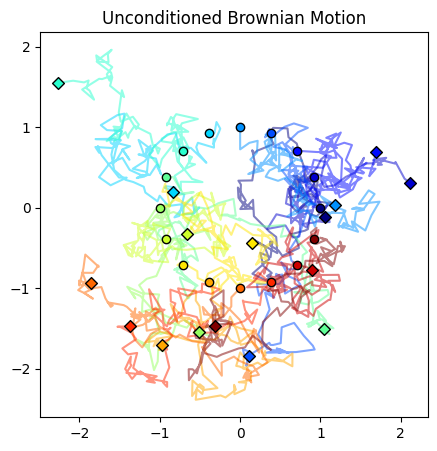

In [4]:
key = jax.random.PRNGKey(2)
forward_trajs = sdes.simulate_traj(bm_sde, forward_init, 2, key)
traj = forward_trajs[0].reshape((-1, sde_config["n_bases"]*sde_config["dim"]))
plot_single_trajectory(traj, "Unconditioned Brownian Motion")


In [5]:
from sdebridge.networks.score_unet import ScoreUNet
import time

    
neural_net = ScoreUNet

network = {
    "output_dim": bm_sde.dim*bm_sde.n_bases,
    "time_embedding_dim": 32,
    "init_embedding_dim": 32,
    "act_fn": "silu",
    "encoder_layer_dims": [64, 32, 16, 8],
    "decoder_layer_dims": [8, 16, 32, 64],
    "batchnorm": True,
}
    
training= {
    "batch_size": 100,
    "load_size": 5000,
    "num_epochs": 200,
    "learning_rate": 1e-2,
    "warmup_steps": 100,
}

target = sample_ellipse(sde_config["n_bases"])
target = jnp.expand_dims(target, axis=0)

def target_sampler(key, num_batches):
    initial_vals = jnp.tile(target, reps=(num_batches, 1, 1, 1))
    return initial_vals


train_key = jax.random.split(key, 2)[0]
start = time.time()
score_state_p = db.learn_p_score(bm_sde, target_sampler, train_key, aux_dim=1, **training, net=neural_net, network_params=network)
end = time.time()
training_time = end - start

Training: 100%|██████████| 200/200 [11:46<00:00,  3.53s/epoch, Epoch=200, loss=1508.2979]


In [6]:
import orbax
from flax.training import orbax_utils
import os

bases = sde_config["n_bases"]

save_path = f"./ckpts/bm/{bases}_landmarks_exact"

score_p_ckpt = {
    "state": score_state_p,
    "training_config": training,
    "network_config": network,
    "sde_config": sde_config,
    "time": training_time,
}

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

save_args = orbax_utils.save_args_from_target(score_p_ckpt)
orbax_checkpointer.save(os.path.abspath(save_path), score_p_ckpt, save_args=save_args, force=True)
print("saved score_p_ckpt")

saved score_p_ckpt


In [7]:
# def load_score_p_ckpt(path):
#     orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
#     score_p_ckpt = orbax_checkpointer.load(path)
#     return score_p_ckpt
# 
# paths = ["./ckpts/bm/8_landmarks_exact", "./ckpts/bm/16_landmarks_exact", "./ckpts/bm/32_landmarks_exact"]
# ckpts = []
# states = []
# scores = []
# times = []
# 
# for path in paths:
#     score_p_ckpt = load_score_p_ckpt(path)
#     ckpts.append(score_p_ckpt)
#     states.append(score_p_ckpt["state"])
#     scores.append(score_fn(score_p_ckpt["state"]))
#     times.append(score_p_ckpt["time"])

In [8]:
def forward_score(t0, x0, t, x):
    x0 = jnp.asarray(x0)
    x = jnp.asarray(x)
    return -(x - x0) / (t - t0)


def error_forward(ts, true_score, trained_score, target, y):
    """mean squared error between true and trained score"""
    true = jax.vmap(true_score, in_axes=(None, None, 0, None))(0, target, ts, y)
    trained = jax.vmap(trained_score, in_axes=(None, 0))(y, ts)
    return jnp.mean((true - trained) ** 2)

ts = jnp.linspace(0, bm_sde.T, 100)
score_p = score_fn(score_state_p)

initial_val = sample_ellipse(sde_config["n_bases"], scale=2.0)

error = error_forward(ts[1:], forward_score, score_p, target,  initial_val)
print(error)

10.087984


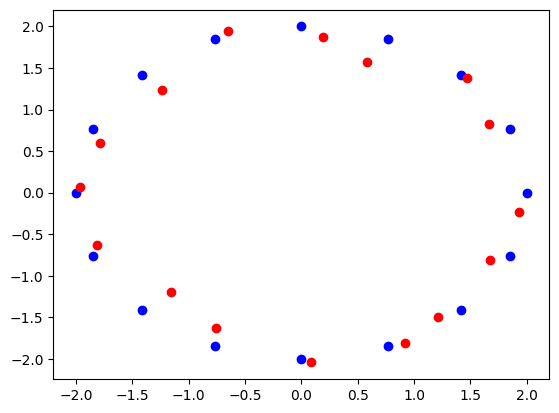

In [9]:
# Plot the true score and the trained score for a circle at t=0.5

true_score = forward_score(0, target, 0.5, initial_val).squeeze()
trained_score = score_p(initial_val, 0.5).squeeze()


plt.scatter(true_score[:, 0], true_score[:, 1], c='b')
plt.scatter(trained_score[:, 0], trained_score[:, 1], c='r')

plt.show()


In [10]:
initial_val = sample_ellipse(sde_config["n_bases"], scale=2.0)
initial_val = jnp.expand_dims(initial_val, axis=0)
score_p = score_fn(score_state_p)
reverse_bm = sdes.reverse(bm_sde, score_p)
backward_trajs = sdes.simulate_traj(reverse_bm, initial_val, 2, train_key)


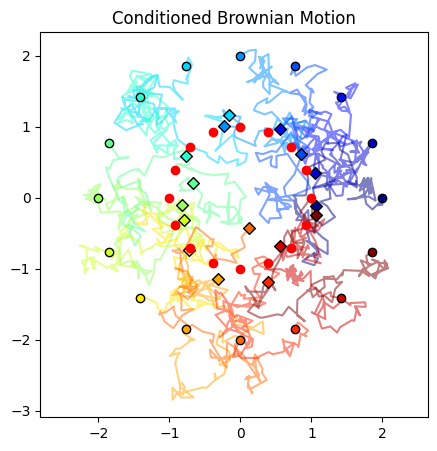

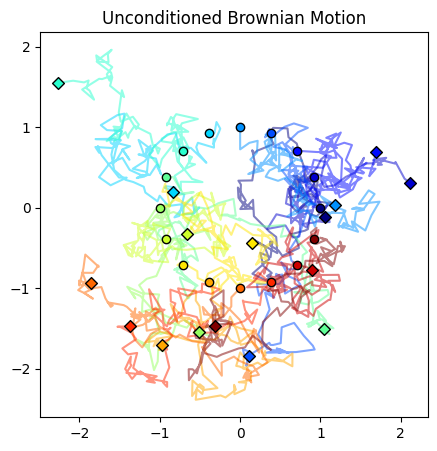

In [11]:
traj = backward_trajs[0].reshape((-1, sde_config["n_bases"]*sde_config["dim"]))
plot_single_trajectory(traj, "Conditioned Brownian Motion")

plt.scatter(target[:, :, 0], target[:, :, 1], c='r', label="Target", zorder=3)
plt.show()

traj = forward_trajs[0].reshape((-1, sde_config["n_bases"]*sde_config["dim"]))
plot_single_trajectory(traj, "Unconditioned Brownian Motion")